In [50]:
from os import listdir
from os.path import isfile, join
import random
from PIL import Image
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import numpy as np
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf

In [51]:
Learning_Rate = 1e-3
width = height = 80
batchSize = 1024
epochs = 200

trainPercentage = 0.80
testPercentage = 0.15
valPercentage = 0.05 

In [52]:
torch.cuda.is_available()

True

In [53]:
path = 'GeneratedImages'
files = [f for f in listdir(path) if isfile(join(path, f))]

#randomise the order of the files list
random.shuffle(files)

In [54]:
def LoadRandomImg():
    path = 'GeneratedImages/' + files[random.randrange(0,len(files))]
    image = Image.open(path)
    
    s = path.split('_')[2]
    angle = s[0:-7]

    transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
    image=transformImg(np.array(image))
    return image, float(angle)

In [55]:
def LoadImg(name):
    path = 'GeneratedImages/' + name
    image = Image.open(path)
    
    s = path.split('_')[1]
    angle = s[0:-7]
    

    transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
    image=transformImg(np.array(image))
    return image, float(angle)

In [56]:
trainFiles, valFiles, testFiles = np.split(files, [int(len(files)*trainPercentage), int(len(files)*trainPercentage) + int(len(files)*(testPercentage))])
trainFiles = np.ndarray.tolist(trainFiles)
trainFilesNotModified = trainFiles.copy()
valFiles = np.ndarray.tolist(valFiles)
testFiles = np.ndarray.tolist(testFiles)

totalBatches = math.ceil(len(trainFiles)/batchSize)

allBatches = []

for i in range(0,totalBatches):
    batch = []
    for i in range(0,batchSize):
        try:
            fileName = trainFiles[0]
            trainFiles.remove(fileName)
        except:
            fileName = files[random.randrange(0,len(files))]
        batch.append(LoadImg(fileName))
    
    allBatches.append(batch)

trainFiles = trainFilesNotModified

In [57]:
def LoadBatch(i):
    images = torch.zeros([batchSize,3,height,width])
    angles = torch.zeros([batchSize])
    for j in range(0,batchSize):
        images[j] = allBatches[i][j][0]
        angles[j] = allBatches[i][j][1]
    return images,angles

In [58]:
def mseTest(set, modelPath, partialSet = True, partialSetPer = 1):
    
    if set == 'test':
        files = testFiles
    elif(set == 'val'):
        files = valFiles
    elif(set == 'train'):
        files = trainFiles
    
    if partialSet:
        random.shuffle(files)
        length = len(files)
        files = files[0:int(length*partialSetPer)]

    error = []

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    Net = torchvision.models.resnet50()
    Net.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)
    Net = Net.to(device)

    #modelPath = '19.torch'
    Net.load_state_dict(torch.load(modelPath))

    for file in files:
        image, trueAngle = LoadImg(file)

        Img = torch.autograd.Variable(image, requires_grad=False).to(device).unsqueeze(0)

        with torch.no_grad():
            Prd = Net(Img)  # Run net

        predAngle = Prd.data.cpu().numpy()

        error.append((trueAngle - predAngle)**2)

    mse = (1/len(testFiles))*(sum(error))

    #print(set + " MSE: ", str(mse[0][0]))
    return mse[0][0]

In [59]:
len(trainFiles)

46084

In [60]:
#--------------Load and set net and optimizer-------------------------------------

# Set device GPU or CPU where the training will take place
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

#load net
#weights='ResNet50_Weights.DEFAULT'
Net = torchvision.models.resnet50()

# Change final layer to predict one value
Net.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True) 

Net = Net.to(device)

# Create adam optimizer
optimizer = torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate) 



#----------------Train------------------------------------------------------------

# Save average loss for display
losses=np.zeros([epochs]) 

currentBatch = 0
max = len(allBatches)*epochs

mseAtEpochForVal = []
mseAtEpochForTrain = []
epochArr = []

# Training loop
for epoch in range(0,epochs):
    t = time.time()
    for batch in range(0,len(allBatches)-1):
        #print("Runing Batch: " + str(batch) + " on Epoch: " + str(epoch))
        
        # Load taining batch
        images,angle = LoadBatch(batch)
        
        # Load image
        images=torch.autograd.Variable(images,requires_grad=False).to(device) 
        
        # Load Ground truth fill level
        angle = torch.autograd.Variable(angle, requires_grad=False).to(device) 
        
        # make prediction
        predLevel=Net(images)
        Net.zero_grad()
        Loss=torch.abs(predLevel-angle).mean()
        
        # Backpropogate loss
        Loss.backward() 
        
        # Apply gradient descent change to weight
        optimizer.step() 
    
    #val set MSE
    mseAtEpochForVal.append(mseTest('val',modelPath))
    mseAtEpochForTrain.append(mseTest('train',modelPath,partialSetPer = 0.05))
    epochArr.append(epoch)

    # Save loss average
    losses[epoch]=Loss.data.cpu().numpy() 

    #Save model weight
    modelPath = str(epoch) + ".torch"
    print("Saving Model: " + modelPath) 
    torch.save(Net.state_dict(),   modelPath)  

    elapsed = time.time() - t
    print('Time To Run Epoch: ' + str(int(elapsed)) + ' Seconds')
    print()

    # Loss
    #print("Epoch: " + str(epoch) + "   Loss=",Loss.data.cpu().numpy())

Saving Model: 0.torch
Time To Run Epoch: 92 Seconds

Saving Model: 1.torch
Time To Run Epoch: 92 Seconds

Saving Model: 2.torch
Time To Run Epoch: 96 Seconds

Saving Model: 3.torch
Time To Run Epoch: 95 Seconds

Saving Model: 4.torch
Time To Run Epoch: 95 Seconds

Saving Model: 5.torch
Time To Run Epoch: 94 Seconds

Saving Model: 6.torch
Time To Run Epoch: 96 Seconds

Saving Model: 7.torch
Time To Run Epoch: 96 Seconds

Saving Model: 8.torch
Time To Run Epoch: 99 Seconds

Saving Model: 9.torch
Time To Run Epoch: 97 Seconds

Saving Model: 10.torch
Time To Run Epoch: 97 Seconds

Saving Model: 11.torch
Time To Run Epoch: 97 Seconds

Saving Model: 12.torch
Time To Run Epoch: 96 Seconds

Saving Model: 13.torch
Time To Run Epoch: 98 Seconds

Saving Model: 14.torch
Time To Run Epoch: 95 Seconds

Saving Model: 15.torch
Time To Run Epoch: 96 Seconds

Saving Model: 16.torch
Time To Run Epoch: 96 Seconds

Saving Model: 17.torch
Time To Run Epoch: 96 Seconds

Saving Model: 18.torch
Time To Run Epo

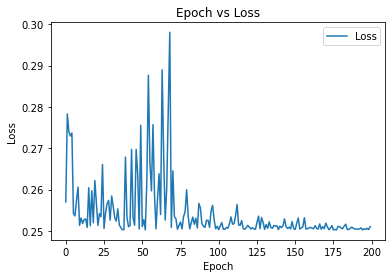

In [61]:
plt.plot(epochArr, losses, label='Loss')

plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

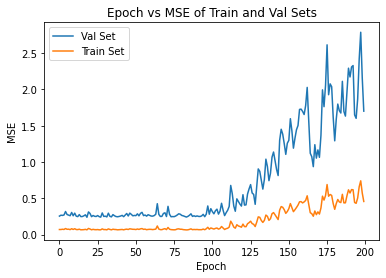

In [62]:
plt.plot(epochArr, mseAtEpochForVal, label='Val Set')
plt.plot(epochArr, mseAtEpochForTrain, label='Train Set')

plt.title('Epoch vs MSE of Train and Val Sets')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()